In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import time
import csv
import h5py
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU, ZeroPadding2D, Input, Lambda, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model, Model
from keras import regularizers, optimizers
from keras.optimizers import RMSprop, Adam
np.random.seed(1234)
from keras.utils import plot_model
import keras.backend.tensorflow_backend as Kback
from IPython.display import clear_output
from keras import backend as K
from keras import objectives
import tensorflow as tf
import scipy.io as sio
from scipy import stats
import scipy as scp
from keras.backend.tensorflow_backend import set_session
from keras.datasets import mnist
from keras.models import load_model
import os
import random
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=1
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
#Load data
f = h5py.File('cropped.mat')

In [3]:
#input_parameters
hrz = 80
vrt = 80
x_train = {}
x_train_small_pre = np.ndarray((14114,hrz,vrt,3),int)
x_train_small = np.ndarray((14114,hrz,vrt,3),int)
x_train = f['bigdata'][()]
print(x_train.shape)


(3, 210, 165, 14114)


In [4]:
x_train_s = np.swapaxes(x_train,0,3)
x_train_s = np.swapaxes(x_train_s,1,2)
print(x_train.shape)
for j in range(0,x_train_s.shape[0]):
    pic = scp.misc.imresize(x_train_s[j,:,:],(hrz,vrt,3))
    x_train_small_pre[j,:,:] = pic 

(3, 210, 165, 14114)


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


(14114, 80, 80, 3)
(80, 80, 3)
192


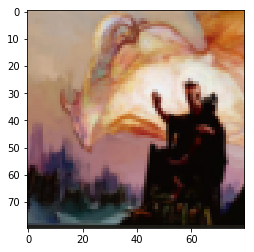

In [5]:
print(x_train_small_pre.shape)
probe = random.randint(0,14114)
testpic = x_train_small_pre[probe,:,:,:]
print(testpic.shape)
plt.imshow(testpic.astype(np.uint8)) 
print(max(testpic[:,0,0]))

0.5843137254901961
0.01568627450980392
149.0
4.0


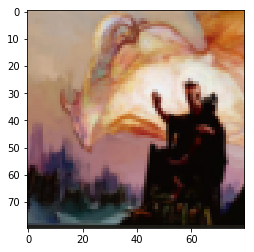

In [6]:
x_train_small = x_train_small_pre/255

testpic_sml = x_train_small[probe,:,:,:]
print(max(testpic_sml[:,0,2]))
print(min(testpic_sml[:,0,2]))

testpic = (x_train_small[probe,:,:,:]*255)
print(max(testpic[:,0,2]))
print(min(testpic[:,0,2]))
plt.imshow(testpic.astype(np.uint8)) 


In [7]:
x_train = np.float32(x_train_small_pre)

x_test = x_train[13000:14000,:,:,:]
x_train = x_train[0:13000,:,:,:]

x_train_flat = x_train.reshape(x_train.shape[0],hrz*vrt*3)/255
x_test_flat = x_test.reshape(x_test.shape[0],hrz*vrt*3)/255
print(x_train.shape)
print(x_test.shape)
print(x_train_flat.shape)
print(x_test_flat.shape)
print(np.amax(x_train_flat))
print(np.amin(x_train_flat))
print(x_train_flat.dtype)

(13000, 80, 80, 3)
(1000, 80, 80, 3)
(13000, 19200)
(1000, 19200)
1.0
0.0
float32


In [8]:
# Network size
digit_size=80
batch_size = 50
latent_1 = 50
dim1 = 64
dim2 = 128
dim3 = 256
epsilon_std=1.0
reg_param = 0.01

In [9]:
#Encoder

X = Input(batch_shape=(batch_size,digit_size*digit_size*3))
x = Reshape((digit_size,digit_size,3))(X) #40x40

x = Conv2D(dim1, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(dim2, (3, 3), activation='relu', padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(x) #20x20

x = Conv2D(dim2, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(dim3, (3, 3), activation='relu', padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(x) #10x10

x = Conv2D(dim3, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(dim3, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x) #5x5
encoded = Flatten()(encoded)
zlayin = Dense(5*5*dim3,activation = 'relu')(encoded)

z_mean = Dense(latent_1**2,name ='z_mean')(zlayin)
z_log_var = Dense(latent_1**2,name ='z_var')(zlayin)

# Create the function samplings
def sampling(args):
    z_mean,z_log_var = args
    epsilon = K.random_normal(shape=(batch_size,latent_1**2), mean=0, stddev=epsilon_std) 
    return z_mean + K.exp(z_log_var)*epsilon

z= Lambda(sampling, output_shape=(latent_1**2,))([z_mean, z_log_var])

#Decoder
zlayout = Dense(5*5*dim3,activation = 'relu')
x0 = Reshape((5,5,dim3))

x1 = Conv2D(dim3, (3, 3), activation='relu', padding='same')
x1 = Conv2D(dim3, (3, 3), activation='relu', padding='same')

x2 = UpSampling2D((2, 2))

x3 = Conv2D(dim3, (3, 3), activation='relu', padding='same')
x3 = Conv2D(dim2, (3, 3), activation='relu', padding='same')

x4 = UpSampling2D((2, 2))

x5 = Conv2D(dim2, (3, 3), activation='relu', padding='same')
x6 = Conv2D(dim1, (3, 3), activation='relu', padding='same')

x7 = UpSampling2D((2, 2))

x8 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')

x9 = UpSampling2D((2, 2))
x10 = Flatten()

x00 = zlayout(z)
x0out = x0(x00)
x1out = x1(x0out)
x2out = x2(x1out)
x3out = x3(x2out)
x4out = x4(x3out)
x5out = x5(x4out)
x6out = x6(x5out)
x7out = x7(x6out)
x8out = x8(x7out)
x9out = x9(x8out)
decoded = x10(x9out)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
def vae_loss(x,x_bar):
    reconst_loss=3*digit_size*digit_size*objectives.binary_crossentropy(x, x_bar) #compares images
    #reconst_loss=objectives.binary_crossentropy(x, x_bar) #compares images
    kl_loss=-0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #compresses representations
    return reconst_loss + kl_loss

In [11]:
# build and compile model
vae=Model(X, decoded)
vae.summary()
#plot_model(vae, to_file='model.png')
vae.compile(optimizer='adam', loss=vae_loss)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (50, 19200)          0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (50, 80, 80, 3)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (50, 80, 80, 64)     1792        reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (50, 80, 80, 128)    73856       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [12]:
# Train the model
nb_epochs=10

history = vae.fit(x_train_flat,x_train_flat, 
        shuffle=True, 
        epochs=nb_epochs, 
        batch_size=batch_size, 
        validation_data=(x_test_flat, x_test_flat))

Train on 13000 samples, validate on 1000 samples
Epoch 1/10
13000/13000 [==============================] - 102s 8ms/step - loss: 12207.0628 - val_loss: 11859.3729
Epoch 2/10
13000/13000 [==============================] - 43s 3ms/step - loss: 11756.9999 - val_loss: 11742.1752
Epoch 3/10
13000/13000 [==============================] - 43s 3ms/step - loss: 11669.1161 - val_loss: 11654.8566
Epoch 4/10
13000/13000 [==============================] - 43s 3ms/step - loss: 11624.4880 - val_loss: 11633.1816
Epoch 5/10
13000/13000 [==============================] - 43s 3ms/step - loss: 11596.1517 - val_loss: 11611.1146
Epoch 6/10
13000/13000 [==============================] - 43s 3ms/step - loss: 11572.9608 - val_loss: 11594.2767
Epoch 7/10
13000/13000 [==============================] - 43s 3ms/step - loss: 11490.6868 - val_loss: 11458.0714
Epoch 8/10
13000/13000 [==============================] - 43s 3ms/step - loss: 11410.1052 - val_loss: 11457.6930
Epoch 9/10
13000/13000 [======================

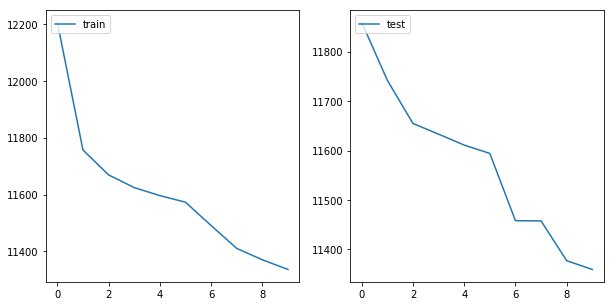

In [15]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2,1)
plt.plot(history.history['loss'])
plt.legend(['train'], loc='upper left')
#plt.ylim((-2000,10000))

ax = plt.subplot(1, 2,2)
plt.plot(history.history['val_loss'])
plt.legend(['test'], loc='upper left')

plt.show()

(1000, 19200)
(50, 19200)


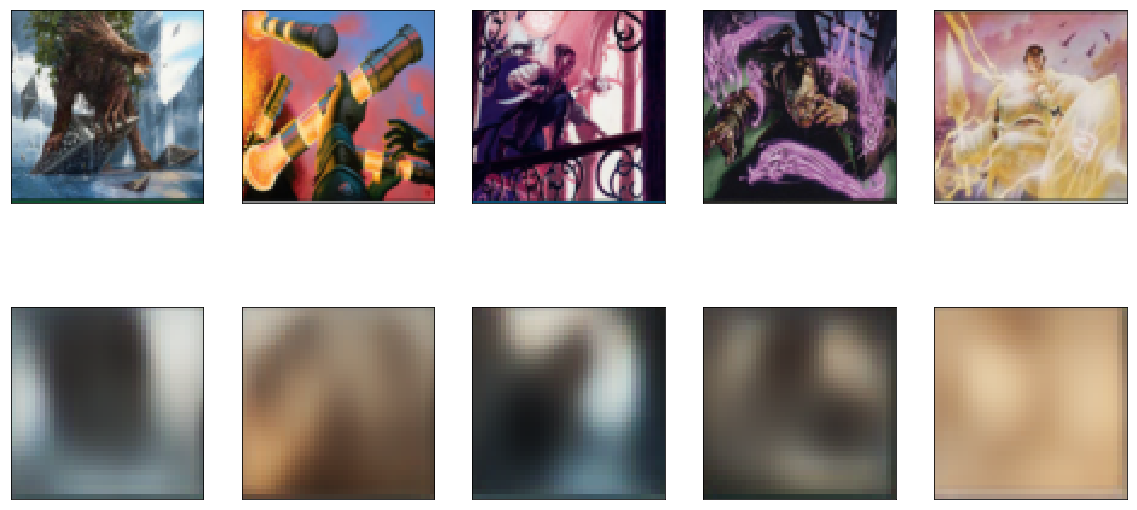

In [16]:
print(x_test_flat.shape)
aind = np.random.randint(999, size=batch_size)
x_test_in = x_test_flat[aind,:]
print(x_test_in.shape)
decoded_imgs = vae.predict(x_test_in,batch_size=batch_size)
n = 5
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_in[i].reshape(hrz, vrt, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(hrz, vrt,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

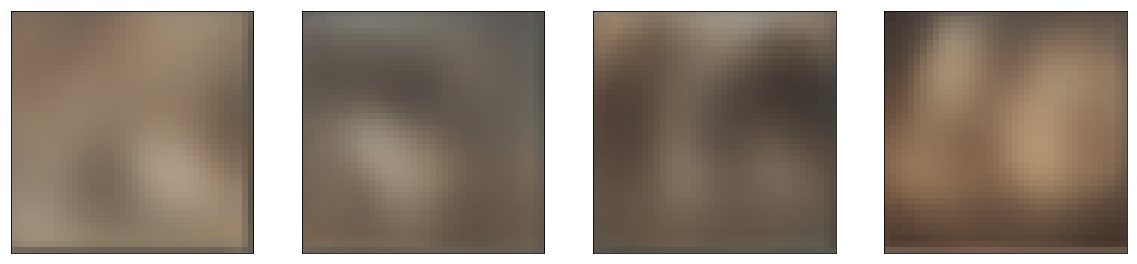

In [19]:
# since the generator treats z as an input, we make z an input layer

latent_shape = latent_1*latent_1
z_input=Input(shape=(latent_shape,))

x00 = zlayout(z_input)
x0out = x0(x00)
x1out = x1(x0out)
x2out = x2(x1out)
x3out = x3(x2out)
x4out = x4(x3out)
x5out = x5(x4out)
x6out = x6(x5out)
x7out = x7(x6out)
x8out = x8(x7out)
x9out = x9(x8out)
X_decoded = x10(x9out)

generator= Model(z_input, X_decoded)

n = 4
plt.figure(figsize=(20, 20))
for i in range(n):
    # display fakes
    z_sample=np.array([np.random.normal(0, 1, latent_shape)])
    sampled_im=generator.predict(z_sample)
    sampled_im = sampled_im[0].reshape(hrz, vrt,3)
    ax = plt.subplot(2, n, i+1)
    plt.imshow(sampled_im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
#generator.save('lowresVAEGEN.h5')